# AdventureWorks Försäljningsanalys
I denna analys undersöker jag AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Jag använder SQL för att hämta data och Python för visualisering och analys

In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Password123")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 17 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\Kevin\AppData\Local\Temp\ipykernel_26400\2042272080.py:22: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [8]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori

### Affärsfråga
Hur många produkter finns i varje kategori?

### Använda tabeller
- Production.ProductCategory  
- Production.ProductSubcategory  
- Production.Product  

### Metod
- Tabellerna sammanfogas med hjälp av JOINs
- Antal **unika produkter** räknas per kategori
- Resultatet visualiseras med ett **vertikalt stapeldiagram**
- Analysera resultatet

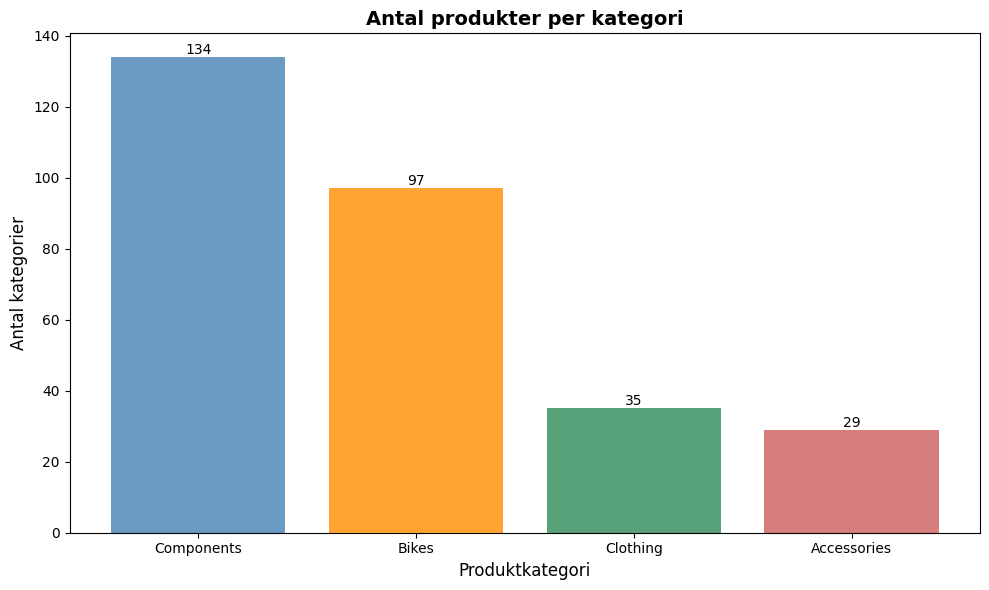

In [ ]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount

FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))

colors = [
    'steelblue', 'darkorange',
    'seagreen','indianred'
]

bars = ax.bar(
    df_vis1['CategoryName'],
    df_vis1['ProductCount'],
    color=colors[:len(df_vis1)], alpha=0.8
    )

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )
    

ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Antal kategorier', fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Insikter - antal produkter per kategori
Components är största kategori med 134 produkter.
Accessories är minst med 29 produkter.

Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar.
Samt att accessories kan vara ett utvecklingsområde.

## Visualisering 2: Total försäljning per produktkategori

### Affärsfråga
Vilka produktkategorier genererar mest intäkter?

### Använda tabeller
- Production.ProductCategory  
- Production.ProductSubcategory  
- Production.Product  
- Sales.SalesOrderDetail  

### Metod
- Tabellerna sammanfogas med JOINs
- Total försäljning beräknas per kategori
- Resultatet sorteras från högst till lägst
- Visualiseras med ett **horisontellt stapeldiagram**

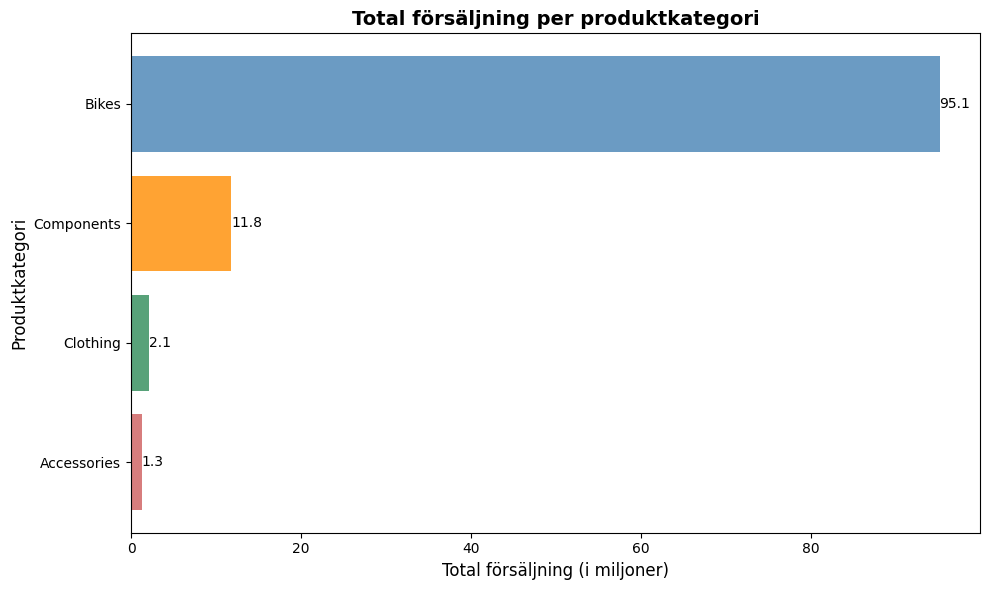

In [22]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.OrderQty * sod.UnitPrice) AS TotalSales
FROM Production.ProductCategory pc

INNER JOIN Production.ProductSubcategory psc
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod
    ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""

df_vis2 = query_df(query_vis2)

df_vis2['TotalSales_M'] = df_vis2['TotalSales'] / 1_000_000

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(
    df_vis2['CategoryName'],
    df_vis2['TotalSales_M'],
    color=colors[:len(df_vis2)], alpha=0.8
)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{width:.1f}',
        va='center',
        ha='left'
    )

ax.set_xlabel('Total försäljning (i miljoner)', fontsize=12)
ax.set_ylabel('Produktkategori', fontsize=12)
ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')

ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Insikter – total försäljning per produktkategori

Det är tydligt att **Bikes** dominerar försäljningen och står för cirka **95,1 miljoner**, vilket gör detta till företagets absolut största produktkategori sett till intäkter.

I andra änden ligger **Accessories**, som endast når omkring **1,3 miljoner** i försäljning. Det visar att denna kategori spelar en betydligt mindre roll för den totala försäljningen jämfört med de övriga kategorierna.

Försäljningsvärdena har beräknats som **OrderQty * UnitPrice**.